# Create a Simple MLP for 1D Regression

This code implements a simple multi-layer perceptron (MLP) model that predicts the average buoyancy in the lower troposphere ($B_L$) using lower free-tropospheric subsaturation ($\mathrm{SUBSAT_L}$) as input. An MLP is a type of deep neural network that consists of at least three layers: an input layer, one or more hidden layers, and an output layer.
 
For context, $B_L$ is related to $\mathrm{SUBSAT_L}$ in the following equation:
$$ B_L = \frac{g}{\overline{\kappa}_L\theta_{e0}}\left[w_B\left(\mathrm{CAPE_L}\right) - w_L\left(\mathrm{SUBSAT_L}\right)\right] $$

The MLP aims to learn this complex relationship, potentially capturing non-linear interactions that may not be immediately apparent in the equation. This code was inspired by articles from [Machine Learning Expidition](https://www.machinelearningexpedition.com/how-to-train-multilayer-perceptron-in-pytorch/) and [Sebastian Raschka](https://sebastianraschka.com/teaching/pytorch-1h/#3-seeing-models-as-computation-graphs)

## Import Necessary Packages

In [2]:
import torch
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
from sklearn.metrics import r2_score
from torch.utils.data import TensorDataset,DataLoader
warnings.filterwarnings('ignore')

## Load and Explore Data

We will use an MLP for regression to predict $B_L$ from $\mathrm{SUBSAT_L}$. We load in daily-mean $\mathrm{SUBSAT_L}$ (K) and $B_L$ (m/s<sup>2</sup>) for Central India.

In [3]:
file = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed/LR_ERA5_IMERG_pr_bl_terms.nc'
data = xr.open_dataset(file)
data = data.sel(lat=slice(18,24),lon=slice(76,83))

x = data.subsat.load()
y = data.bl.load()

We can generate exploratory plots to better understand the distribution of the data, and the relationship between $\mathrm{SUBSAT_L}$ and $B_L$. We can see from our plots that the variables have similar-but-opposite distributions and are negatively correlated: as $\mathrm{SUBSAT_L}$ increases (i.e., the lower free troosphere becomes drier), $B_L$ decreases. Since this relationship is approaximately lienar, it should be relatively easy to model.

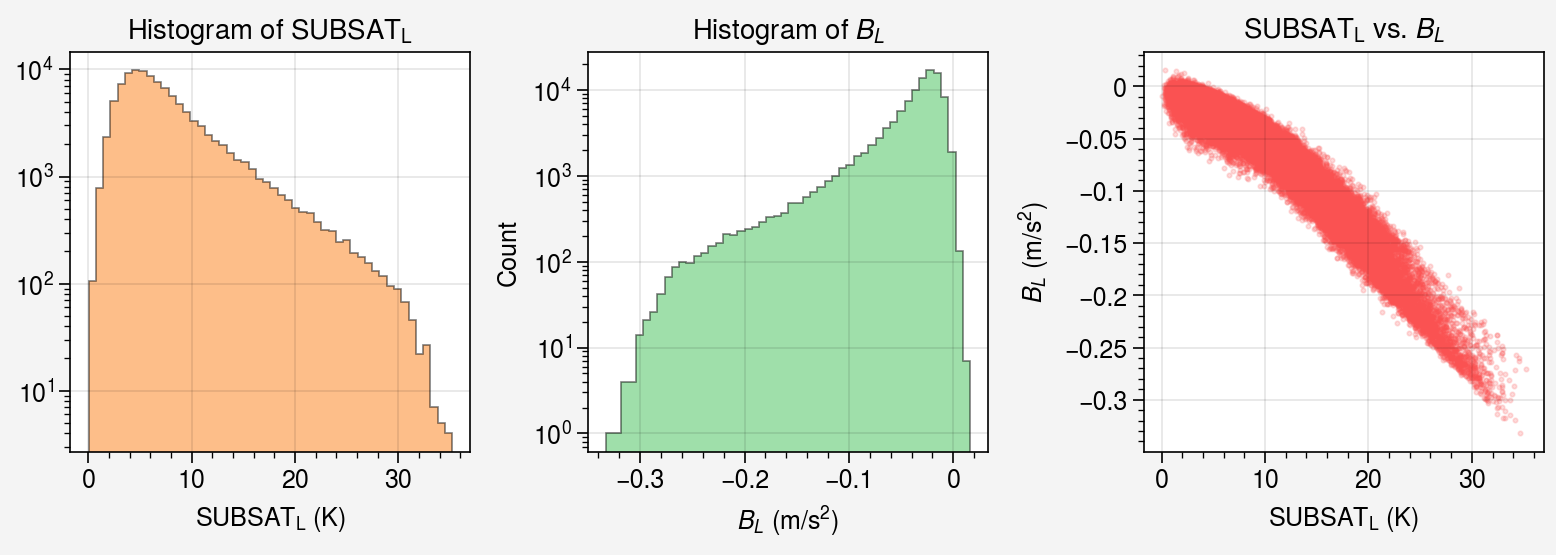

In [4]:
fig,axs = pplt.subplots(nrows=1,ncols=3,refwidth=2,share=False)
axs[0].format(title='Histogram of $SUBSAT_L$',xlabel='$SUBSAT_L$ (K)',yscale='log',yformatter='log')
axs[1].format(title='Histogram of $\mathit{B_L}$',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Count',yscale='log',yformatter='log')
axs[2].format(title='$SUBSAT_L$ vs. $\mathit{B_L}$',xlabel='$SUBSAT_L$ (K)',ylabel='$\mathit{B_L}$ (m/s$^2$)')
axs[0].hist(x.values.flatten(),bins=50,filled=True,color='orange6',edgecolor='k',alpha=0.5)
axs[1].hist(y.values.flatten(),bins=50,filled=True,color='green6',edgecolor='k',alpha=0.5)
axs[2].scatter(x.values.flatten(),y.values.flatten(),color='red6',marker='.',markersize=10,alpha=0.2)
pplt.show()

## Preprocess the Input and Target Data

The `subset()` function allows us to temporally subset our input (*x*) and target (*y*) data by selecting specific years. It will later be used to divide our data into training, validation, and test sets. When dealing with temporal data, you must maintain temporal continuity within each set while ensuring no overlap between them. The splitting method should be carefully selected to ensure a high likelihood of consistent distribution shapes across all sets.

The `array()` function reformats our subsetted data to make it compatible with PyTorch. It flattens our 3D Xarray.DataArrays (time × lat × lon) into 1D NumPy arrays. We maintain 64-bit precision during this conversion to ensure accuracy in subsequent processing steps.

In [5]:
def subset(x,y,startyear,endyear):
    years   = np.arange(startyear,endyear+1)
    xsubset = x.sel(time=x['time.year'].isin(years))
    ysubset = y.sel(time=y['time.year'].isin(years))
    def array(xsubset,ysubset):
        return xsubset.values.flatten().astype(np.float64),ysubset.values.flatten().astype(np.float64)
    xarray,yarray = array(xsubset,ysubset)
    return xarray,yarray

The `normalize()` function applies z-score normalization to our data, centering it around 0 with a standard deviation of 1. It calculates normalization parameters (the mean and standard deviation) if not provided. We typically derive these parameters from the training set and apply them to the training, validation, and test sets. This ensures that the model learns to generalize from the training data (mitigate overfitting).

In [6]:
def normalize(array,mean=None,std=None):
    if mean is None:
        mean = np.mean(array)
    if std is None:
        std  = np.std(array)
    return (array-mean)/std,mean,std

The `preprocess()` function streamlines our data preparation workflow, combining splitting, array conversion, and normalization steps for training, validation, and test sets.

In [7]:
def preprocess(x,y,years,training=True,normparams=None):
    xarray,yarray = subset(x,y,years[0],years[1])
    if training:
        xnorm,xmean,xstd = normalize(xarray)
        ynorm,ymean,ystd = normalize(yarray)
        normparams = {'xmean':xmean,'xstd':xstd,'ymean':ymean,'ystd':ystd}
    else:
        if normparams is None:
            raise ValueError("'normparams' must be provided for validation and test sets.")
        xnorm,_,_ = normalize(xarray,normparams['xmean'],normparams['xstd'])
        ynorm,_,_ = normalize(yarray,normparams['ymean'],normparams['ystd'])
    xtensor = torch.FloatTensor(xnorm)
    ytensor = torch.FloatTensor(ynorm)
    return (xtensor,ytensor,normparams) if training else (xtensor,ytensor)

We will work with smaller timespans within our 21-year dataset, so that we can more wuickly train our MLP. We allocate 6 years for training (2000-2005), 2 years for validation (2006-2007), and 2 years for testing (2008-2009).

In [8]:
trainyears = (2000,2005)
valyears   = (2006,2007)
testyears  = (2008,2009)

xtrain,ytrain,normparams = preprocess(x,y,trainyears,training=True,normparams=False)
xval,yval   = preprocess(x,y,valyears,training=False,normparams=normparams)
xtest,ytest = preprocess(x,y,testyears,training=False,normparams=normparams)

## Create Data Loaders

Now that we have preprocessed the training, validation, and test sets, we create a custom class that inherits from PyTorch's `TensorDataset`. This class is tailored to handle our specific data structure, where each sample has a single input feature ($\mathrm{CAPE_L}$) and a single target value ($B_L$). The class reshapes input and target tensors to ensure they have the shape (*n*<sub>samples</sub>, 1), where 1 represents the single feature for both input and target. This structure optimizes compatibility with PyTorch's DataLoader, an iterator designed to efficiently load data in batches.

In [9]:
class DATASET(TensorDataset):
    def __init__(self,xtensor,ytensor):
        self.inputs  = xtensor.view(-1,1)
        self.targets = ytensor.view(-1,1)
    def __getitem__(self,index):
        onex = self.inputs[index]
        oney = self.targets[index]
        return onex,oney
    def __len__(self):
        return self.targets.shape[0]

In [10]:
traindataset = DATASET(xtrain,ytrain)
valdataset   = DATASET(xval,yval)
testdataset  = DATASET(xtest,ytest)

Processing data in batches is more memory-efficient and can lead to faster training. The batch size determines the number of samples processed simultaneously. Our model's inputs and targets are 1D PyTorch tensors of length *n*. To ensure a whole number of batches, we want the batch size to be a factor of *n*. Additionally, we aim to use the same batch size for both the training data (which has a larger *n*) and the validation/test data (which have the same, smaller *n*).

The `batch()` function identifies shared batch sizes suitable for two pairs of PyTorch 1D tensors. It calculates all available factors for each tensor individually, then finds common factors between them. We filter these factors to disregard unreasinably small or large batch sizes. The function prints each valid common batch size along with the number of batches it would create for both training and validation sets. 

In [11]:
def batch(tensor1,tensor2):
    def factors(n):
        factors = set()
        for i in range(1,int(n**0.5)+1):
            if n%i==0:
                factors.add(i)
                factors.add(n//i)
        return factors
    n1 = tensor1.shape[0]
    n2 = tensor2.shape[0]
    commonfactors   = factors(n1).intersection(factors(n2))
    validbatchsizes = [f for f in commonfactors if 50<=f<=800]
    for batchsize in validbatchsizes:
        print(f'Batch Size: {batchsize:<3} | Tensor 1: {n1//batchsize:<3} batches | Tensor 2: {n2//batchsize:<3} batches')

batch(xtrain,xval)

Batch Size: 644 | Tensor 1: 48  batches | Tensor 2: 16  batches
Batch Size: 161 | Tensor 1: 192 batches | Tensor 2: 64  batches
Batch Size: 56  | Tensor 1: 552 batches | Tensor 2: 184 batches
Batch Size: 184 | Tensor 1: 168 batches | Tensor 2: 56  batches
Batch Size: 448 | Tensor 1: 69  batches | Tensor 2: 23  batches
Batch Size: 322 | Tensor 1: 96  batches | Tensor 2: 32  batches
Batch Size: 64  | Tensor 1: 483 batches | Tensor 2: 161 batches
Batch Size: 92  | Tensor 1: 336 batches | Tensor 2: 112 batches
Batch Size: 736 | Tensor 1: 42  batches | Tensor 2: 14  batches
Batch Size: 224 | Tensor 1: 138 batches | Tensor 2: 46  batches
Batch Size: 368 | Tensor 1: 84  batches | Tensor 2: 28  batches
Batch Size: 112 | Tensor 1: 276 batches | Tensor 2: 92  batches


Now we can use PyTorch’s `DataLoader` class to sample from our datasets. We set the model hyperparameter `BATCHSIZE` based on the results from above. We create DataLoaders for the training, validation, and test sets. For the training set, we enable random shuffling. Shuffling at each epoch prevents the model from memorizing the order of the data, enhancing its ability to generalize. For the validation and test sets, we don't enable shuffling, since the order is not important for evaluation.

In [12]:
BATCHSIZE   = 322
trainloader = DataLoader(dataset=traindataset,batch_size=BATCHSIZE,shuffle=True)
valloader   = DataLoader(dataset=traindataset,batch_size=BATCHSIZE,shuffle=True)
testloader  = DataLoader(dataset=testdataset,batch_size=BATCHSIZE,shuffle=False)

## Define the Model

We define our MLP architecture by creating a class that inherits from PyTorch's `nn.Module`, the base class for all neural network modules in PyTorch. The `__init__()` constructor defines the network's structure, and the `forward()` method specifies how the input data passes through the network.

In the network below, input data passes through the first linear layer, then through a specified activation function, repeats this process for the hidden layer, and then goes through the output layer. Activation functions introduce non-linearity into the model. Without them, the network would just be a complex linear function, incapable of learning non-linear relationships. We chose ReLU specifically because it only allows non-negative values, which aligns well with our goal of predicting (non-negative) precipitation values.

In [13]:
class MLP(torch.nn.Module):
    def __init__(self,inputsize,hiddensize,outputsize,activation):
        super(MLP,self).__init__()                  
        self.activation = activation()      
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(inputsize,hiddensize),  # Input layer to first hidden layer
            self.activation,
            torch.nn.Linear(hiddensize,hiddensize), # First hidden layer to second hidden layer
            self.activation,
            torch.nn.Linear(hiddensize,outputsize)) # Second hidden layer to output layer
    def forward(self,x):
        logits = self.layers(x)
        return logits

## Initialize the Model

We now set the remaining hyperparameters for our model. `INPUTSIZE` and `OUTPUTSIZE` are both set to 1, reflecting our single input feature ($\mathrm{CAPE_L}$) and single output feature (l$B_L$). `HIDDENSIZE` defines the number of neurons in each hidden layer. `ACTIVATION` determines the activation to use after the first two layers. These hyperparameters are used to initialize our MLP model.

In [14]:
INPUTSIZE  = 1
OUTPUTSIZE = 1
HIDDENSIZE = 64
ACTIVATION = torch.nn.Softmax

model = MLP(INPUTSIZE,HIDDENSIZE,OUTPUTSIZE,ACTIVATION)
print(model)

MLP(
  (activation): Softmax(dim=None)
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Softmax(dim=None)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Softmax(dim=None)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


We can find out the number of trainable parameters for our model. Trainable paramaters are paramaters that are updated during training (where `required_grad=True`).

In [15]:
nparams = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of Trainable Parameters:', nparams)

Number of Trainable Parameters: 4353


## Train the Model

We configure the training process by setting up the loss function (`CRITERION`) and `OPTIMIZER`. For regression tasks like ours, MSE is an appropriate loss function. We choose the Adam optimizer for its adaptive learning rate capabilities. `LEARNING` determines the learning rate, or step size for weight updates during training. You want this value to balance rapid convergence (higher values) and stability (lower values). The optimizer is initialized with the model's parameters and the specified learning rate.

In [16]:
CRITERION = torch.nn.MSELoss()
LEARNING  = 0.005
OPTIMIZER = torch.optim.Adam(model.parameters(),lr=LEARNING)

We now create a training loop that iterates over the entire dataset for a specified number of epochs (`NEPOCHS`). For each epoch, we train and validate the model using the `train()` and `validate()` functions, respectively. Both functions process the data in batches and calculate the average loss for the entire dataset, but they serve different purposes.

The `train()` function sets the model to training mode, computing gradients and updating the model's weights. This allows the model to learn from the training data to minimize the loss. The `validate()` function sets the model to evaluation mode, and operates without computing gradients. We use it with our validation set to monitor performance and check for overfitting, without adjusting the weights.

After each epoch, we store the training and validation losses, and print the results to track the model's progress over time.

In [17]:
def train(model,trainloader,criterion,optimizer):
    model.train()
    runningloss = 0.0
    for inputs,targets in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss    = criterion(outputs,targets)
        loss.backward()
        optimizer.step()
        runningloss += loss.item()*inputs.size(0)
    return runningloss/len(trainloader.dataset)

def validate(model,valloader,criterion):
    model.eval()
    runningloss = 0.0
    with torch.no_grad():
        for inputs,targets in valloader:
            outputs = model(inputs)
            loss    = criterion(outputs,targets)
            runningloss += loss.item()*inputs.size(0)
    return runningloss/len(valloader.dataset)

In [18]:
NEPOCHS     = 20
trainlosses = []
vallosses   = []

for epoch in range(NEPOCHS):
    trainloss = train(model,trainloader,CRITERION,OPTIMIZER)
    valloss   = validate(model,valloader,CRITERION)
    trainlosses.append(trainloss)
    vallosses.append(valloss)
    print(f' Epoch: {epoch+1:>2}/{NEPOCHS:<2} | Training Loss: {trainloss:.4f} | Validation Loss: {valloss:.4f}')

 Epoch:  1/20 | Training Loss: 0.9212 | Validation Loss: 0.7153
 Epoch:  2/20 | Training Loss: 0.4703 | Validation Loss: 0.3109
 Epoch:  3/20 | Training Loss: 0.2435 | Validation Loss: 0.1827
 Epoch:  4/20 | Training Loss: 0.1293 | Validation Loss: 0.0876
 Epoch:  5/20 | Training Loss: 0.0716 | Validation Loss: 0.0613
 Epoch:  6/20 | Training Loss: 0.0570 | Validation Loss: 0.0535
 Epoch:  7/20 | Training Loss: 0.0523 | Validation Loss: 0.0513
 Epoch:  8/20 | Training Loss: 0.0503 | Validation Loss: 0.0497
 Epoch:  9/20 | Training Loss: 0.0495 | Validation Loss: 0.0488
 Epoch: 10/20 | Training Loss: 0.0488 | Validation Loss: 0.0488
 Epoch: 11/20 | Training Loss: 0.0486 | Validation Loss: 0.0491
 Epoch: 12/20 | Training Loss: 0.0484 | Validation Loss: 0.0487
 Epoch: 13/20 | Training Loss: 0.0481 | Validation Loss: 0.0483
 Epoch: 14/20 | Training Loss: 0.0482 | Validation Loss: 0.0479
 Epoch: 15/20 | Training Loss: 0.0479 | Validation Loss: 0.0479
 Epoch: 16/20 | Training Loss: 0.0480 | 

We can plot the training and validation loss to make sure they are decreasing over time.

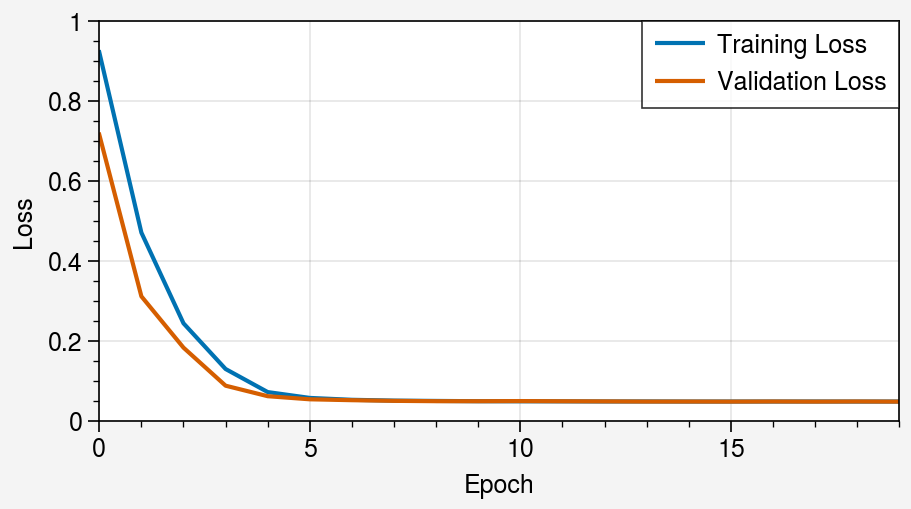

In [19]:
fig,ax = pplt.subplots(nrows=1,ncols=1,refheight=2,refwidth=4)
ax.format(xlabel='Epoch',xticks=5,ylabel='Loss',ylim=(0,1))
ax.plot(trainlosses,label='Training Loss')
ax.plot(vallosses,label='Validation Loss')
ax.legend(loc='ur',ncols=1)

## Evaluate the Model

After training and validating,we can evaluate the model on the test set. The `test()` function sets the model to evaluate mode, and then passes the data in batches to get predictions and the average loss.

In [20]:
def test(model,testloader,criterion):
    model.eval()
    runningloss = 0.0
    alloutputs  = []
    with torch.no_grad():
        for inputs,targets in testloader:
            outputs = model(inputs)
            loss    = criterion(outputs,targets)
            runningloss += loss.item()*inputs.size(0)
            alloutputs.append(outputs.cpu().numpy())
    return runningloss/len(testloader.dataset),np.array(np.concatenate(alloutputs).flatten())

In [21]:
testloss,ypred = test(model,testloader,CRITERION)
print(f'Test Loss: {testloss:.4f}')

Test Loss: 0.0553


The `denormalize()` function reverses the normalization applied earlier that was necessary for training the model, using the normalization parameters saved from the training data. We apply this function to denormalize both our output and target *y*-values, representing the model-predicted and actual $B_L$ values respectively, allowing for direct comparison in the original scale.

In [22]:
def denormalize(normtensor,mean,std):
    return np.array(normtensor)*std+mean

In [23]:
realbl = denormalize(ytest,normparams['ymean'],normparams['ystd'])
predbl = denormalize(ypred,normparams['ymean'],normparams['ystd'])

## Plot Results

Using our denormalized data, we can plot our actual and predicted $B_L$ to better understand model performance. The results show a very strong correlation between actual and predicted $B_L$, indicating that our MLP performs well. This was expected, given the fairly linear relationship between $\mathrm{SUBSAT_L}$ and $B_L$ plotted earlier. Additionally, we find that the model captures the bulk of the distribution well, but has more difficulty capturing the tail ends.

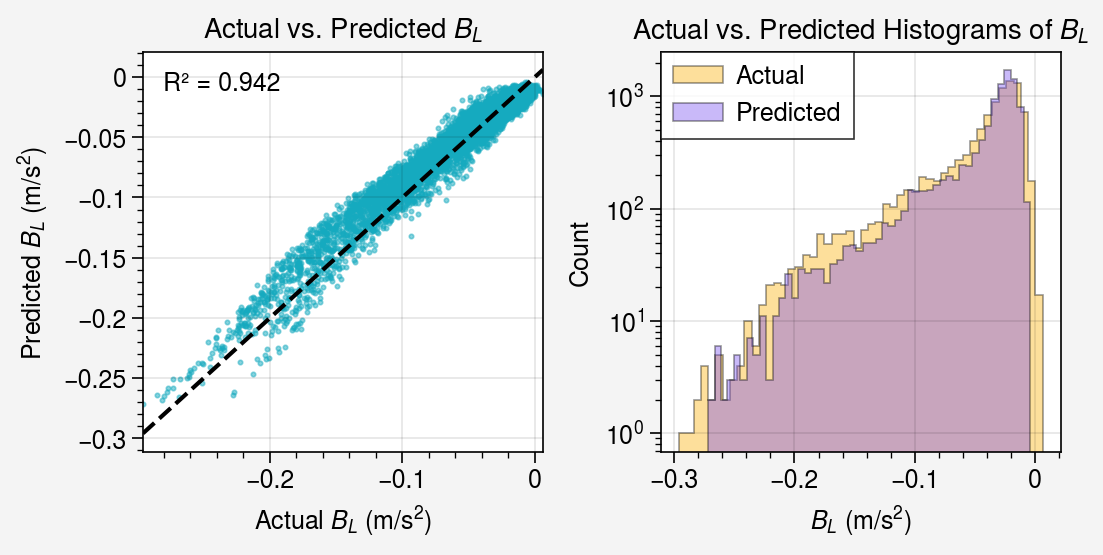

In [24]:
fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=2,share=False)
axs[0].format(title='Actual vs. Predicted $\mathit{B_L}$',xlabel='Actual $\mathit{B_L}$ (m/s$^2$)',ylabel='Predicted $\mathit{B_L}$ (m/s$^2$)')
axs[1].format(title='Actual vs. Predicted Histograms of $\mathit{B_L}$',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Count',yscale='log',yformatter='log')
axs[0].scatter(realbl,predbl,color='cyan6',marker='.',markersize=10,alpha=0.5)
axs[0].plot([min(min(realbl),min(predbl)),max(max(realbl),max(predbl))],[min(min(realbl),min(predbl)),max(max(realbl),max(predbl))],'k--')
axs[0].text(0.05,0.95,f'R² = {r2_score(realbl,predbl):.3f}',transform=axs[0].transAxes,verticalalignment='top',horizontalalignment='left')
axs[1].hist(realbl,bins=50,filled=True,color='yellow6',edgecolor='k',alpha=0.4,label='Actual')
axs[1].hist(predbl,bins=50,filled=True,color='violet6',edgecolor='k',alpha=0.4,label='Predicted')
axs[1].legend(loc='ul',ncols=1)
pplt.show()